# Pipelines

Almost every machine learning problem involves several steps before you arrive at a final result. Commonly, you must

* load the data
* clean the data
* extract or engineer features
* fit a model
* evaluate this model
* iterate

Scikit-learn is designed from the ground up to make these steps easy for users with minimal boilerplate. Recall that there are three (really, four) main objects and interfaces in scikit-learn

* Estimators
* Predictors
* Transformers

The scikit-learn [pipeline](http://scikit-learn.org/stable/modules/pipeline.html) abstraction builds on these interfaces to allow us to build chain of transformers and estimators and use the pipeline, as if it were an estimator itself. 

We've already seen some steps that are common in a machine learning pipeline. In the coming sections, we're going to dive into some more methods that we may also want to use. First, let's fix ideas.

## Transformer Interface

Recall the transformer interface. A transformer is intended to filter or modify the data in a supervised or unsupervised way.

```python
new_data = obj.transform(data)
```

The interface is

```python
class Transformer:

    def fit(self, X, y=None):
        """"""
        return self
        
    def transform(self, X, y=None):
        return X
        
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X, y)
```

## Estimator Interface

Recall the estimator interface.

```python
class Estimator:
  
    def fit(self, X, y=None):
        """Fit model to data X (and y)"""
        self.some_attribute = self.some_fitting_method(X, y)
        return self
            
    def predict(self, X_test):
        """Make prediction based on passed features"""
        pred = self.make_prediction(X_test)
        return pred
```

## Putting it Together

```python
from sklearn.pipeline import Pipeline

estimator = Pipeline([
    ('transformer1', Transformer(*args1)),
    ('transformer2', Transformer(*args2)),
    ('estimator', Estimator(*args))
])

estimator.fit(X_train, y_train)

y_fitted = estimator.predict(X_test)
```

By chaining together transformer estimators, our code is much easier to deal with than it would have been otherwise.

Under the hood, this calls `fit` on the first transformer, then `transform` on `X` and passes the transformed `X` to the next stop until the final estimator. The pipeline simply calls `fit` on the transformed `X` and `y`.

### Example: Chaining PCA and Logistic Regression

Recall that we can use PCA for unsupervised dimensionality reduction.

In [1]:
from sklearn import linear_model, decomposition, datasets
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

logistic = linear_model.LogisticRegression()

pca = decomposition.PCA()

In [2]:
estimator = Pipeline(steps=[
    ('pca', pca), 
    ('logistic', logistic)
])

In [3]:
digits = datasets.load_digits()

(X_digits, X_digits_test, 
 y_digits, y_digits_test) = train_test_split(digits.data, digits.target, test_size=.2)

In [4]:
X_digits[:2]

array([[  0.,   0.,   0.,  11.,  10.,   0.,   0.,   0.,   0.,   0.,   8.,
         16.,   5.,   0.,   0.,   0.,   0.,   3.,  16.,  10.,   4.,  11.,
          0.,   0.,   0.,  11.,  13.,   0.,   9.,  16.,   0.,   0.,   0.,
         12.,  13.,   5.,  14.,  16.,   8.,   0.,   0.,   3.,  12.,  14.,
         16.,  11.,   3.,   0.,   0.,   0.,   0.,  10.,  11.,   0.,   0.,
          0.,   0.,   0.,   0.,  11.,   8.,   0.,   0.,   0.],
       [  0.,   0.,   3.,  14.,  13.,  12.,  14.,   0.,   0.,   0.,  11.,
         14.,  12.,  15.,   9.,   0.,   0.,   0.,  16.,   5.,   3.,  16.,
          2.,   0.,   0.,   1.,   9.,   1.,  10.,  12.,   0.,   0.,   0.,
          0.,   0.,   7.,  16.,  14.,   6.,   0.,   0.,   0.,   4.,  16.,
         16.,  11.,   1.,   0.,   0.,   0.,   0.,  15.,   5.,   0.,   0.,
          0.,   0.,   0.,   6.,  13.,   0.,   0.,   0.,   0.]])

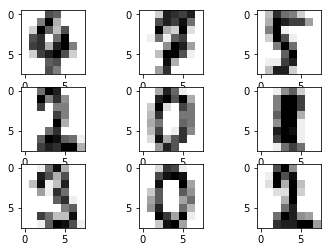

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 3)

def plot_image(ax, img):
    ax.imshow(img.reshape(8, 8), cmap=plt.cm.gray_r)
    
for i in range(3):
    for j in range(3):
        plot_image(axes[i, j], X_digits[i * 3 + j])

In [6]:
y_digits[:9]

array([4, 7, 5, 2, 0, 1, 3, 0, 2])

Calling fit on the estimator runs the whole pipeline.

In [7]:
estimator.fit(X_digits, y_digits)

Pipeline(steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('logistic', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

Each fitted transformer or estimator is available from the pipeline.

In [8]:
estimator.named_steps.keys()

dict_keys(['pca', 'logistic'])

How did we do across classes?

In [9]:
estimator.score(X_digits_test, y_digits_test)

0.96666666666666667

In [10]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_digits_test, 
                 estimator.predict(X_digits_test))

array([[38,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 31,  0,  0,  0,  0,  0,  0,  1,  1],
       [ 0,  0, 39,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 35,  0,  0,  0,  1,  2,  0],
       [ 0,  0,  0,  0, 38,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 27,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1, 40,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  0, 37,  0,  0],
       [ 0,  1,  0,  0,  0,  1,  0,  0, 27,  0],
       [ 0,  0,  0,  0,  0,  1,  0,  0,  1, 36]])

If you find naming the steps a little tedious, there is a convenience function called `make_pipeline` that will use the class names for you, avoiding collisions.

In [11]:
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(pca, logistic)

pipe.named_steps

{'logisticregression': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False),
 'pca': PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
   svd_solver='auto', tol=0.0, whiten=False)}

In [12]:
pipe = make_pipeline(pca, pca, logistic)

pipe.named_steps

{'logisticregression': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False),
 'pca-1': PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
   svd_solver='auto', tol=0.0, whiten=False),
 'pca-2': PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
   svd_solver='auto', tol=0.0, whiten=False)}

### Avoid Contamination

The following is an example of a common gotcha in statistical learning.

In [ ]:
import numpy as np

from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression


newsgroups = fetch_20newsgroups(categories=[
    'sci.space', 'alt.atheism', 'comp.graphics'
])

(X, X_test, 
 y, y_test) = train_test_split(newsgroups.data, newsgroups.target)

vectorizer = TfidfVectorizer()
X_vect = vectorizer.fit_transform(X)

clf = LogisticRegression()

param_grid = {
    'C': np.logspace(-1, 2, num=4)
}

grid = GridSearchCV(clf, param_grid=param_grid, cv=5)

grid.fit(X_vect, y)

Can anyone see what we did wrong here?

### Exercise: 

Create a pipeline out of a [`StandardScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) and [`Ridge`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge) regression and apply it to the Boston housing dataset (load the data using `sklearn.datasets.load_boston`). Try adding the [`PolynomialFeatures`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) transformer as a second preprocessing step, and grid-search the degree of the polynomials (try 1, 2 and 3).

Hint: See the scikit-learn [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn-pipeline-pipeline) on passing parameters to grid search over to the steps in a pipeline.

In [13]:
from sklearn.datasets import load_boston

In [19]:
dta = load_boston()

In [25]:
print(dta['DESCR'])

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

In [27]:
dta['data'].shape

(506, 13)

In [31]:
dta.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR'])

In [28]:
import pandas as pd

In [33]:
df = pd.DataFrame(dta['data'],columns=dta['feature_names'])

In [34]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [35]:
df.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
dtype: int64

In [40]:
y = dta['target']

In [41]:
x = dta['data']

In [42]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import ridge
from sklearn.model_selection import train_test_split

In [43]:
scl = StandardScaler()

In [44]:
scl.fit(x)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [48]:
x_tran = scl.transform(x)

In [ ]:
x_test, = train_test_split(x_tran,y)

In [51]:
from sklearn import linear_model

In [53]:
mdl = linear_model.LinearRegression()

In [ ]:
mdl.fit()

In [47]:
x

array([[  6.32000000e-03,   1.80000000e+01,   2.31000000e+00, ...,
          1.53000000e+01,   3.96900000e+02,   4.98000000e+00],
       [  2.73100000e-02,   0.00000000e+00,   7.07000000e+00, ...,
          1.78000000e+01,   3.96900000e+02,   9.14000000e+00],
       [  2.72900000e-02,   0.00000000e+00,   7.07000000e+00, ...,
          1.78000000e+01,   3.92830000e+02,   4.03000000e+00],
       ..., 
       [  6.07600000e-02,   0.00000000e+00,   1.19300000e+01, ...,
          2.10000000e+01,   3.96900000e+02,   5.64000000e+00],
       [  1.09590000e-01,   0.00000000e+00,   1.19300000e+01, ...,
          2.10000000e+01,   3.93450000e+02,   6.48000000e+00],
       [  4.74100000e-02,   0.00000000e+00,   1.19300000e+01, ...,
          2.10000000e+01,   3.96900000e+02,   7.88000000e+00]])

In [ ]:
# %load solutions/4a-ridge-grid.py
import numpy as np

from sklearn.datasets import load_boston
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, train_test_split


boston = load_boston()
X, y = boston.data, boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=.2,
                                                    random_state=123)

param_grid = {
    'ridge__alpha': np.logspace(-1, 3, 5),
    'polynomialfeatures__degree': [1, 2, 3]
}

pipeline = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(),
    Ridge()
)

estimator = GridSearchCV(pipeline, param_grid=param_grid, cv=5)
estimator.fit(X_train, y_train)

print(estimator.score(X_test, y_test))
print(estimator.best_score_)
print(estimator.best_params_)
